In [1]:
import jax
import jax.numpy as jnp
import flox

In [2]:
from flox.util import key_chain


seed = 42
chain = key_chain(42)

In [3]:
dim = 2
num_particles = 100

dmin = 0.1

In [4]:
from functools import partial
from flox.geom import Torus

torus = Torus(jnp.ones(dim))

sigma = jnp.power(2, 1./6.) * dmin
soften = 1e-5

lennard_jones_potential = flox.bulk.pairwise_penalty(
    partial(flox.bulk.lennard_jones_edge, sigma=sigma, soften=soften),
    torus
)

In [40]:
from jax_dataclasses import pytree_dataclass

from jaxtyping import Float, Array  # type: ignore

from flox._src.flow.api import Transformed

Particles = Float[Array, "P D"]
Auxiliaries = Float[Array, "P F"]

@pytree_dataclass(frozen=True)
class State:
    p: jnp.ndarray
    q: jnp.ndarray


def sample_base(key, num_particles, dim, aux_std):
    chain = key_chain(key)
    p = jax.random.uniform(next(chain), shape=(num_particles, dim))
    q = jax.random.normal(next(chain), shape=(num_particles, dim)) * aux_std
    ldj = harmonic(q, aux_std)
    return Transformed(State(p, q), ldj)


def harmonic(x, std):
    return jnp.sum(0.5 * jnp.square(x / std))


def base_potential(s: State, std: float):
    return harmonic(s.q, std=std)


def target_potential(s: State, std: float):
    return 10 * lennard_jones_potential(s.p) + harmonic(s.q, std=std)

In [25]:
import haiku as hk

from flox._src.bulk.convolution import conv_nd, density_features, fft_conv, indices_and_weights


class NormedResidual(hk.Module):
    
    def __init__(self):
        super().__init__()
    
    def __call__(self, inp, out):
        inp_mean = jnp.mean(inp, keepdims=True)
        inp_std = jnp.std(inp, keepdims=True)
        out_mean = jnp.mean(out, keepdims=True)
        out_std = jnp.std(out, keepdims=True)
        scale = hk.get_parameter("scale", shape=(), init=hk.initializers.Constant(1.))
        offset = hk.get_parameter("offset", shape=(), init=hk.initializers.Constant(0.))
        
        out = inp + out
        out = (out - out_mean) / (out_std + 1e-6) * inp_std * scale + inp_mean + offset
        return out
    
class MixConv(hk.Module):
    
    def __init__(self, fout, res, kernel_size=3):
        super().__init__()
        self.kernel_size = kernel_size
        self.fout = fout
        self.res = res
        
    def __call__(self, inp):
        ndims = len(self.res)
        
        mix = hk.get_parameter("mix", shape=(2 * self.fout, self.fout), init=hk.initializers.Constant(0.))
        
        fin = inp.shape[-1]
        std = jnp.sqrt(1./(fin + self.fout))
        freq_kernel = hk.get_parameter(
            "spectral_kernel",
            shape=(*self.res, self.fout, fin),
            init=hk.initializers.TruncatedNormal(std))
        
        std = jnp.sqrt(1./(fin + self.fout))
        spat_kernel = hk.get_parameter(
            "spatial_kernel",
            shape=(*((self.kernel_size,) * ndims), self.fout, fin),
            init=hk.initializers.TruncatedNormal(std))
        
        bias = hk.get_parameter(
            "bias",
            shape=(*((1,) * ndims), self.fout),
            init=hk.initializers.Constant(0.)
        )
        
        out = hk.Linear(self.fout, name="mixer")(jnp.concatenate((
            conv_nd(inp, spat_kernel),
            fft_conv(inp, freq_kernel, len(self.res), conserve_energy=False)
        ), axis=-1))
        
        return out

        
class ResNet(hk.Module):
    def __init__(self, inner, num_layers=1, encoder=None, decoder=None, output_residual=False, activation=jax.nn.silu):
        super().__init__()
        def body(x):
            return NormedResidual()(x, activation(inner()(x)))
        self.encoder = encoder
        self.decoder = decoder
        self.stack = hk.experimental.layer_stack(num_layers)(body)
        self.output_residual = output_residual
    
    def __call__(self, inp):
        out = inp
        if self.encoder is not None:
            out = self.encoder()(out)
        out = self.stack(out)
        if self.decoder is not None:
            out = self.decoder()(out)
        if self.output_residual:
            out = NormedResidual()(inp, out)
        return out


class AuxConditioner(hk.Module):
    
    def __init__(self, num_layers, hidden, res, smoothen):
        super().__init__()
        self.num_layers = num_layers
        self.hidden = hidden
        self.res = res
        self.smoothen = smoothen
    
    def __call__(self, pos):
        idxs, weights = indices_and_weights(pos, self.res)
        inp = density_features(pos, self.res, idxs, weights, smoothen=self.smoothen)
        out = ResNet(
            partial(MixConv, self.hidden, self.res),
            encoder=partial(MixConv, self.hidden, self.res),
            decoder=partial(MixConv, 2, self.res),
        )(inp)
        out = NormedResidual()(inp[..., 1:], out)
        return flox.bulk.gather(out, idxs) 

In [55]:

from flox._src.flow.api import Transformed
from flox._src.geom.manifold import Manifold, PointN
from flox.flow import Affine, Lambda

class AuxUpdater(hk.Module):

    def __init__(self, num_layers, num_hidden, resolution, smoothen):
        super().__init__()
        self.num_layers = num_layers
        self.num_hidden = num_hidden
        self.resolution = resolution
        self.smoothen = smoothen

    def __call__(self, state: State):
        shift = AuxConditioner(self.num_layers, self.num_hidden, self.resolution, self.smoothen)(state.p) * 1e-2
        # shift, scale = jnp.split(cond(state.p), 2, axis=-1)
        return Affine(shift, jnp.zeros_like(shift))

class PosUpdater(hk.Module):

    def __init__(self, manifold: Manifold, init_scale: float=1e-3):
        super().__init__()
        self.manifold = manifold
        self.init_scale = init_scale

    def __call__(self, state: State) -> Lambda[PointN, PointN]:
        shift = state.q.sum(axis=-2) * self.init_scale
        
        def shift_fn(x, shift) -> Transformed[PointN]:
            return Transformed(self.manifold.shift(x, shift), jnp.zeros(()))
        
        return Lambda(
            forward=lambda x: shift_fn(x, shift),
            inverse=lambda x: shift_fn(x, -shift)
        )

In [56]:
from functools import partial

relax = flox.bulk.relax(
    torus.shift,
    flox.bulk.pairwise_penalty(
        partial(flox.bulk.soft_edge, dmin=dmin),
        torus
    )
)

In [57]:
resolution = (32, 32)

In [58]:
import haiku as hk
import lenses
from flox._src.flow.api import Transform
from flox._src.flow.impl import Affine
from flox._src.util.func import Lens
import flox.nn as fnn

class Relaxation(hk.Module):
    def __call__(self, s: State):
        _, dq = relax(s.p)
        dq = dq[..., None, :]
        return Affine(dq, jnp.zeros_like(dq))


def get_q(state: State):
    return state.q

def update_q(state: State, new):
    return lenses.bind(state).q.set(new)

def get_pos(state: State):
    return state.p

def update_pos(state: State, new):
    return lenses.bind(state).p.set(new)


def make_aux_coupling() -> Transform[State, State]:
    return flox.flow.Pipe([
        flox.flow.SimpleCoupling(
            AuxUpdater(
                num_layers=2,
                num_hidden=32,
                resolution=resolution,
                smoothen=10
            ),
            Lens(get_q, update_q)
        ),
    ])

def make_inner_flow(num_blocks) -> Transform[State, State]:
    return flox.flow.Pipe([
        flox.nn.haiku.LayerStack(make_aux_coupling, num_layers=num_blocks),
        flox.flow.SimpleCoupling(
            PosUpdater(torus),
            Lens(get_pos, update_pos)
        )
    ])

def make_full_flow(num_blocks) -> Transform[State, State]:
    return flox.flow.Pipe([
        flox.flow.SimpleCoupling(
            Relaxation(),
            Lens(get_q, update_q)
        ),
        make_inner_flow(num_blocks),
    ])

flow = flox.nn.haiku.to_haiku(partial(make_full_flow, num_blocks=2))

In [59]:
from flox.flow import Transformed 

num_particles = 100

p = jax.random.uniform(next(chain), shape=(num_particles, dim))
q = jax.random.normal(next(chain), shape=(num_particles, dim)) * 1e-3

params = jax.jit(flow.pure.init)(
    next(chain),
    State(p, q)
)

In [60]:
forward_ = jax.jit(flow.with_params(params).forward)

In [61]:
a = sample_base(next(chain), num_particles=num_particles, dim=dim, aux_std=1e-3)
b, dq = jax.jit(relax)(a.obj.p)
out = forward_(a.obj)

(DeviceArray(6.3365364, dtype=float32),
 DeviceArray(1.7270679e+09, dtype=float32))

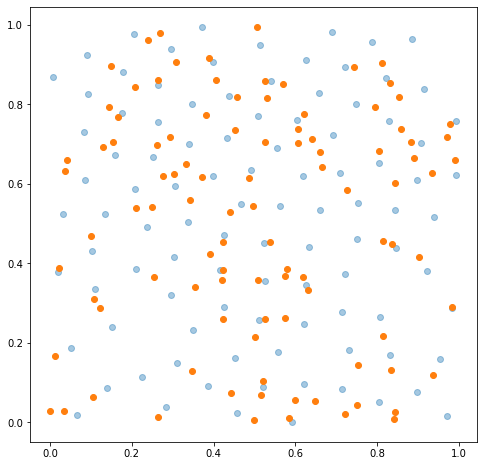

In [62]:
from matplotlib import pyplot as plt  # type: ignore
plt.figure(figsize=(8, 8))

plt.scatter(*b.T, alpha=0.4)
plt.scatter(*out.obj.p.T)

target_potential(State(b, a.obj.q + dq), std=1.), target_potential(out.obj, std=1.)

In [63]:
import optax

NUM_ITERS = 3_000
PLOT_INTERVAL = 50
LEARNING_RATE = 1e-4

optim = optax.adam(learning_rate=LEARNING_RATE)
opt_state = optim.init(params)

In [64]:
from flox.nn import train
from flox.flow import DatasetSampler

step = train.free_energy_step(partial(target_potential, std=1.), flow, optim, partial(sample_base, num_particles=num_particles, dim=dim, aux_std=1e-2), 32)
step = jax.jit(step)

In [65]:
loss, params, opt_state = step(next(chain), params, opt_state)

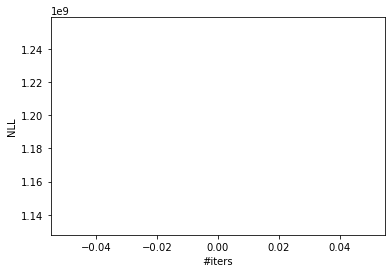

loss: 1.864e+09:   1%|          | 16/3000 [01:02<3:15:18,  3.93s/it]


KeyboardInterrupt: 

In [66]:
import time

from IPython import display  # type: ignore
from IPython.display import clear_output
from matplotlib import pyplot as plt  # type: ignore
from tqdm import tqdm

pbar = tqdm(range(NUM_ITERS))
agg_loss = train.RunningMean(0., 0)
losses = []


for i in pbar:
    
    loss, params, opt_state = step(next(chain), params, opt_state)  # type: ignore
    agg_loss = agg_loss.update(loss)
    losses.append(agg_loss.value)
    
    pbar.set_description(f"loss: {agg_loss.value:.4}")
    if not i % PLOT_INTERVAL:
        
        display.clear_output(wait=True)
        plt.plot(losses)
        plt.ylabel("NLL")
        plt.xlabel("#iters")
    
        plt.show()
        time.sleep(0.001)